In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import confusion_matrix, roc_curve, auc, classification_report
import seaborn as sns
from itertools import cycle

In [30]:

class ROCAnalyzer:
    def __init__(self, data_path):
        """
        Inicializa o analisador de curva ROC
        """
        self.data_path = data_path
        self.data = None
        self.X = None
        self.y = None
        self.X_train = None
        self.X_test = None
        self.y_train = None
        self.y_test = None
        self.classifiers = {}
        self.results = {}
        
    def load_and_preprocess_data(self):
        """
        Carrega e preprocessa o dataset agaricus-lepiota
        """
        # Carregar dados
        column_names = [
            'class', 'cap-shape', 'cap-surface', 'cap-color', 'bruises', 'odor',
            'gill-attachment', 'gill-spacing', 'gill-size', 'gill-color',
            'stalk-shape', 'stalk-root', 'stalk-surface-above-ring',
            'stalk-surface-below-ring', 'stalk-color-above-ring',
            'stalk-color-below-ring', 'veil-type', 'veil-color', 'ring-number',
            'ring-type', 'spore-print-color', 'population', 'habitat'
        ]
        
        self.data = pd.read_csv(self.data_path, header=None, names=column_names)
        
        print("Dataset carregado com sucesso!")
        print(f"Shape: {self.data.shape}")
        print(f"Classes: {self.data['class'].value_counts()}")
        
        # Preprocessar dados categóricos
        label_encoders = {}
        data_encoded = self.data.copy()
        
        for column in data_encoded.columns:
            le = LabelEncoder()
            data_encoded[column] = le.fit_transform(data_encoded[column])
            label_encoders[column] = le
            
        # Separar features e target
        self.X = data_encoded.drop('class', axis=1)
        self.y = data_encoded['class']
        
        print("Dados preprocessados com sucesso!")
        return self
        
    def split_data(self, test_size=0.3, random_state=42):
        """
        Divide os dados em treino e teste
        """
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(
            self.X, self.y, test_size=test_size, random_state=random_state, stratify=self.y
        )
        
        print(f"Dados divididos - Treino: {len(self.X_train)}, Teste: {len(self.X_test)}")
        return self
        
    def initialize_classifiers(self):
        """
        Inicializa diferentes classificadores para comparação
        """
        self.classifiers = {
            'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
            'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000),
            'SVM': SVC(probability=True, random_state=42),
            'Naive Bayes': GaussianNB()
        }
        
        print(f"Classificadores inicializados: {list(self.classifiers.keys())}")
        return self
        
    def train_classifiers(self):
        """
        Treina todos os classificadores
        """
        print("\nTreinando classificadores...")
        
        for name, classifier in self.classifiers.items():
            print(f"Treinando {name}...")
            classifier.fit(self.X_train, self.y_train)
            
        print("Todos os classificadores foram treinados!")
        return self
        
    def calculate_confusion_matrices(self):
        """
        Calcula as matrizes de confusão para cada classificador
        """
        print("\nCalculando Matrizes de Confusão...")
        
        for name, classifier in self.classifiers.items():
            # Fazer predições
            y_pred = classifier.predict(self.X_test)
            
            # Calcular matriz de confusão
            cm = confusion_matrix(self.y_test, y_pred)
            
            # Extrair valores da matriz de confusão
            tn, fp, fn, tp = cm.ravel()
            
            # Calcular métricas
            tpr = tp / (tp + fn)  # True Positive Rate (Sensibilidade/Recall)
            fpr = fp / (fp + tn)  # False Positive Rate
            tnr = tn / (tn + fp)  # True Negative Rate (Especificidade)
            precision = tp / (tp + fp)
            accuracy = (tp + tn) / (tp + tn + fp + fn)
            
            # Armazenar resultados
            self.results[name] = {
                'confusion_matrix': cm,
                'tn': tn, 'fp': fp, 'fn': fn, 'tp': tp,
                'tpr': tpr, 'fpr': fpr, 'tnr': tnr,
                'precision': precision, 'accuracy': accuracy,
                'y_pred': y_pred
            }
            
            # Imprimir resultados
            print(f"\n{name}:")
            print(f"  Matriz de Confusão:\n{cm}")
            print(f"  True Positive Rate (TPR/Sensibilidade): {tpr:.4f}")
            print(f"  False Positive Rate (FPR): {fpr:.4f}")
            print(f"  True Negative Rate (TNR/Especificidade): {tnr:.4f}")
            print(f"  Precisão: {precision:.4f}")
            print(f"  Acurácia: {accuracy:.4f}")
            
        return self
        
    def plot_confusion_matrices(self):
        """
        Plota as matrizes de confusão
        """
        fig, axes = plt.subplots(2, 2, figsize=(12, 10))
        axes = axes.ravel()
        
        for idx, (name, results) in enumerate(self.results.items()):
            cm = results['confusion_matrix']
            
            sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                       xticklabels=['Comestível', 'Venenoso'],
                       yticklabels=['Comestível', 'Venenoso'],
                       ax=axes[idx])
            
            axes[idx].set_title(f'Matriz de Confusão - {name}')
            axes[idx].set_xlabel('Predição')
            axes[idx].set_ylabel('Real')
            
        plt.tight_layout()
        plt.savefig('/home/netorapg/projects/ML/confusion_matrices.png', dpi=300, bbox_inches='tight')
        plt.show()
        
        return self
        
    def calculate_roc_curves(self):
        """
        Calcula as curvas ROC e AUC para cada classificador
        """
        print("\nCalculando Curvas ROC...")
        
        plt.figure(figsize=(10, 8))
        colors = cycle(['blue', 'red', 'green', 'orange'])
        
        for (name, classifier), color in zip(self.classifiers.items(), colors):
            # Obter probabilidades de predição
            if hasattr(classifier, "predict_proba"):
                y_scores = classifier.predict_proba(self.X_test)[:, 1]
            else:
                y_scores = classifier.decision_function(self.X_test)
                
            # Calcular curva ROC
            fpr, tpr, thresholds = roc_curve(self.y_test, y_scores)
            roc_auc = auc(fpr, tpr)
            
            # Armazenar resultados ROC
            self.results[name]['fpr_curve'] = fpr
            self.results[name]['tpr_curve'] = tpr
            self.results[name]['thresholds'] = thresholds
            self.results[name]['auc'] = roc_auc
            
            # Plotar curva ROC
            plt.plot(fpr, tpr, color=color, lw=2,
                    label=f'{name} (AUC = {roc_auc:.4f})')
            
            print(f"{name} - AUC: {roc_auc:.4f}")
            
        # Plotar linha diagonal (classificador aleatório)
        plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Classificador Aleatório (AUC = 0.5)')
        
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('Taxa de Falsos Positivos (1 - Especificidade)')
        plt.ylabel('Taxa de Verdadeiros Positivos (Sensibilidade)')
        plt.title('Curvas ROC - Comparação dos Classificadores')
        plt.legend(loc="lower right")
        plt.grid(True, alpha=0.3)
        
        plt.savefig('/home/netorapg/projects/ML/roc_curves.png', dpi=300, bbox_inches='tight')
        plt.show()
        
        return self
        
    def generate_detailed_report(self):
        """
        Gera um relatório detalhado dos resultados
        """
        print("\n" + "="*80)
        print("RELATÓRIO DETALHADO - ANÁLISE DE CURVA ROC")
        print("="*80)
        
        # Resumo dos dados
        print(f"\nDados do Dataset:")
        print(f"  - Total de amostras: {len(self.data)}")
        print(f"  - Features: {len(self.X.columns)}")
        print(f"  - Amostras de treino: {len(self.X_train)}")
        print(f"  - Amostras de teste: {len(self.X_test)}")
        
        # Ranking por AUC
        sorted_results = sorted(self.results.items(), key=lambda x: x[1]['auc'], reverse=True)
        
        print(f"\nRanking dos Classificadores por AUC:")
        for idx, (name, results) in enumerate(sorted_results, 1):
            print(f"  {idx}. {name}: {results['auc']:.4f}")
            
        # Detalhes de cada classificador
        print(f"\nDetalhes por Classificador:")
        for name, results in self.results.items():
            print(f"\n{name}:")
            print(f"  ├─ Acurácia: {results['accuracy']:.4f}")
            print(f"  ├─ Precisão: {results['precision']:.4f}")
            print(f"  ├─ TPR (Sensibilidade): {results['tpr']:.4f}")
            print(f"  ├─ FPR: {results['fpr']:.4f}")
            print(f"  ├─ TNR (Especificidade): {results['tnr']:.4f}")
            print(f"  └─ AUC: {results['auc']:.4f}")
            
        # Interpretação dos resultados
        print(f"\nInterpretação dos Resultados:")
        best_classifier = sorted_results[0][0]
        best_auc = sorted_results[0][1]['auc']
        
        print(f"  • Melhor classificador: {best_classifier} (AUC = {best_auc:.4f})")
        
        if best_auc >= 0.9:
            performance = "excelente"
        elif best_auc >= 0.8:
            performance = "boa"
        elif best_auc >= 0.7:
            performance = "razoável"
        else:
            performance = "ruim"
            
        print(f"  • Performance geral: {performance}")
        print(f"  • Todos os classificadores têm AUC > 0.5, superando o classificador aleatório")
        
    def run_complete_analysis(self):
        """
        Executa análise completa de ROC
        """
        print("Iniciando Análise Completa de Curva ROC")
        print("="*50)
        
        (self.load_and_preprocess_data()
         .split_data()
         .initialize_classifiers()
         .train_classifiers()
         .calculate_confusion_matrices()
         .plot_confusion_matrices()
         .calculate_roc_curves()
         .generate_detailed_report())
        
        print(f"\nAnálise concluída! Gráficos salvos em:")
        print(f"  - /home/netorapg/projects/ML/confusion_matrices.png")
        print(f"  - /home/netorapg/projects/ML/roc_curves.png")
analyzer = ROCAnalyzer('/home/netorapg/projects/ML/14-out/mushroom/agaricus-lepiota.data')



In [31]:


class TestROCAnalyzer(unittest.TestCase):
    """Test suite for ROCAnalyzer class"""
    
    def setUp(self):
        """Set up test fixtures"""
        self.data_path = '/home/netorapg/projects/ML/14-out/mushroom/agaricus-lepiota.data'
        
    @patch('pandas.read_csv')
    def test_initialization(self, mock_read_csv):
        """Test ROCAnalyzer initialization"""
        from roc_mushroom import ROCAnalyzer
        
        analyzer = ROCAnalyzer(self.data_path)
        
        self.assertEqual(analyzer.data_path, self.data_path)
        self.assertIsNone(analyzer.data)
        self.assertIsNone(analyzer.X)
        self.assertIsNone(analyzer.y)
        self.assertEqual(analyzer.classifiers, {})
        self.assertEqual(analyzer.results, {})
        
    @patch('pandas.read_csv')
    def test_load_and_preprocess_data(self, mock_read_csv):
        """Test data loading and preprocessing"""
        from roc_mushroom import ROCAnalyzer
        
        # Create mock data
        mock_data = pd.DataFrame({
            'class': ['e', 'p', 'e', 'p'],
            'cap-shape': ['x', 'b', 'f', 's'],
            'cap-surface': ['s', 's', 'y', 'y'],
            'cap-color': ['n', 'y', 'w', 'g'],
            'bruises': ['t', 'f', 't', 'f'],
            'odor': ['p', 'a', 'l', 'n']
        })
        mock_read_csv.return_value = mock_data
        
        analyzer = ROCAnalyzer(self.data_path)
        result = analyzer.load_and_preprocess_data()
        
        # Verify method returns self for chaining
        self.assertEqual(result, analyzer)
        # Verify data was loaded
        self.assertIsNotNone(analyzer.data)
        # Verify X and y were created
        self.assertIsNotNone(analyzer.X)
        self.assertIsNotNone(analyzer.y)
        # Verify class column removed from X
        self.assertNotIn('class', analyzer.X.columns)
        
    @patch('pandas.read_csv')
    def test_split_data(self, mock_read_csv):
        """Test data splitting"""
        from roc_mushroom import ROCAnalyzer
        
        # Create mock data
        mock_data = pd.DataFrame({
            'class': ['e'] * 50 + ['p'] * 50,
            'feature1': np.random.rand(100),
            'feature2': np.random.rand(100)
        })
        mock_read_csv.return_value = mock_data
        
        analyzer = ROCAnalyzer(self.data_path)
        analyzer.load_and_preprocess_data()
        result = analyzer.split_data(test_size=0.3, random_state=42)
        
        # Verify method returns self
        self.assertEqual(result, analyzer)
        # Verify train/test split occurred
        self.assertIsNotNone(analyzer.X_train)
        self.assertIsNotNone(analyzer.X_test)
        self.assertIsNotNone(analyzer.y_train)
        self.assertIsNotNone(analyzer.y_test)
        # Verify split ratio
        total_samples = len(analyzer.X_train) + len(analyzer.X_test)
        self.assertEqual(total_samples, 100)
        
    def test_initialize_classifiers(self):
        """Test classifier initialization"""
        from roc_mushroom import ROCAnalyzer
        
        analyzer = ROCAnalyzer(self.data_path)
        result = analyzer.initialize_classifiers()
        
        # Verify method returns self
        self.assertEqual(result, analyzer)
        # Verify classifiers were created
        self.assertEqual(len(analyzer.classifiers), 4)
        self.assertIn('Random Forest', analyzer.classifiers)
        self.assertIn('Logistic Regression', analyzer.classifiers)
        self.assertIn('SVM', analyzer.classifiers)
        self.assertIn('Naive Bayes', analyzer.classifiers)
        
    @patch('pandas.read_csv')
    def test_train_classifiers(self, mock_read_csv):
        """Test classifier training"""
        from roc_mushroom import ROCAnalyzer
        
        # Create mock data
        mock_data = pd.DataFrame({
            'class': ['e'] * 50 + ['p'] * 50,
            'feature1': np.random.rand(100),
            'feature2': np.random.rand(100)
        })
        mock_read_csv.return_value = mock_data
        
        analyzer = ROCAnalyzer(self.data_path)
        analyzer.load_and_preprocess_data()
        analyzer.split_data()
        analyzer.initialize_classifiers()
        
        result = analyzer.train_classifiers()
        
        # Verify method returns self
        self.assertEqual(result, analyzer)
        # Verify all classifiers were fitted
        for name, classifier in analyzer.classifiers.items():
            self.assertTrue(hasattr(classifier, 'classes_'))
            
    @patch('pandas.read_csv')
    def test_calculate_confusion_matrices(self, mock_read_csv):
        """Test confusion matrix calculation"""
        from roc_mushroom import ROCAnalyzer
        
        # Create mock data
        np.random.seed(42)
        mock_data = pd.DataFrame({
            'class': ['e'] * 50 + ['p'] * 50,
            'feature1': np.random.rand(100),
            'feature2': np.random.rand(100)
        })
        mock_read_csv.return_value = mock_data
        
        analyzer = ROCAnalyzer(self.data_path)
        analyzer.load_and_preprocess_data()
        analyzer.split_data()
        analyzer.initialize_classifiers()
        analyzer.train_classifiers()
        
        result = analyzer.calculate_confusion_matrices()
        
        # Verify method returns self
        self.assertEqual(result, analyzer)
        # Verify results were calculated for all classifiers
        self.assertEqual(len(analyzer.results), 4)
        # Verify metrics are present
        for name, metrics in analyzer.results.items():
            self.assertIn('confusion_matrix', metrics)
            self.assertIn('tpr', metrics)
            self.assertIn('fpr', metrics)
            self.assertIn('tnr', metrics)
            self.assertIn('precision', metrics)
            self.assertIn('accuracy', metrics)
            
    @patch('matplotlib.pyplot.savefig')
    @patch('matplotlib.pyplot.show')
    @patch('pandas.read_csv')
    def test_plot_confusion_matrices(self, mock_read_csv, mock_show, mock_savefig):
        """Test confusion matrix plotting"""
        from roc_mushroom import ROCAnalyzer
        
        # Create mock data
        np.random.seed(42)
        mock_data = pd.DataFrame({
            'class': ['e'] * 50 + ['p'] * 50,
            'feature1': np.random.rand(100),
            'feature2': np.random.rand(100)
        })
        mock_read_csv.return_value = mock_data
        
        analyzer = ROCAnalyzer(self.data_path)
        analyzer.load_and_preprocess_data()
        analyzer.split_data()
        analyzer.initialize_classifiers()
        analyzer.train_classifiers()
        analyzer.calculate_confusion_matrices()
        
        result = analyzer.plot_confusion_matrices()
        
        # Verify method returns self
        self.assertEqual(result, analyzer)
        # Verify plot was saved
        mock_savefig.assert_called_once()
        mock_show.assert_called_once()
        
    @patch('matplotlib.pyplot.savefig')
    @patch('matplotlib.pyplot.show')
    @patch('pandas.read_csv')
    def test_calculate_roc_curves(self, mock_read_csv, mock_show, mock_savefig):
        """Test ROC curve calculation"""
        from roc_mushroom import ROCAnalyzer
        
        # Create mock data
        np.random.seed(42)
        mock_data = pd.DataFrame({
            'class': ['e'] * 50 + ['p'] * 50,
            'feature1': np.random.rand(100),
            'feature2': np.random.rand(100)
        })
        mock_read_csv.return_value = mock_data
        
        analyzer = ROCAnalyzer(self.data_path)
        analyzer.load_and_preprocess_data()
        analyzer.split_data()
        analyzer.initialize_classifiers()
        analyzer.train_classifiers()
        analyzer.calculate_confusion_matrices()
        
        result = analyzer.calculate_roc_curves()
        
        # Verify method returns self
        self.assertEqual(result, analyzer)
        # Verify AUC was calculated for all classifiers
        for name, metrics in analyzer.results.items():
            self.assertIn('auc', metrics)
            self.assertIn('fpr_curve', metrics)
            self.assertIn('tpr_curve', metrics)
            self.assertIn('thresholds', metrics)
            # AUC should be between 0 and 1
            self.assertGreaterEqual(metrics['auc'], 0.0)
            self.assertLessEqual(metrics['auc'], 1.0)
            
    @patch('pandas.read_csv')
    def test_generate_detailed_report(self, mock_read_csv):
        """Test detailed report generation"""
        from roc_mushroom import ROCAnalyzer
        
        # Create mock data
        np.random.seed(42)
        mock_data = pd.DataFrame({
            'class': ['e'] * 50 + ['p'] * 50,
            'feature1': np.random.rand(100),
            'feature2': np.random.rand(100)
        })
        mock_read_csv.return_value = mock_data
        
        analyzer = ROCAnalyzer(self.data_path)
        analyzer.load_and_preprocess_data()
        analyzer.split_data()
        analyzer.initialize_classifiers()
        analyzer.train_classifiers()
        analyzer.calculate_confusion_matrices()
        analyzer.calculate_roc_curves()
        
        # Capture printed output
        with patch('builtins.print') as mock_print:
            analyzer.generate_detailed_report()
            # Verify report was generated (print was called)
            self.assertTrue(mock_print.called)
            
    @patch('matplotlib.pyplot.savefig')
    @patch('matplotlib.pyplot.show')
    @patch('pandas.read_csv')
    def test_run_complete_analysis(self, mock_read_csv, mock_show, mock_savefig):
        """Test complete analysis workflow"""
        from roc_mushroom import ROCAnalyzer
        
        # Create mock data
        np.random.seed(42)
        mock_data = pd.DataFrame({
            'class': ['e'] * 100 + ['p'] * 100,
            'feature1': np.random.rand(200),
            'feature2': np.random.rand(200),
            'feature3': np.random.rand(200)
        })
        mock_read_csv.return_value = mock_data
        
        analyzer = ROCAnalyzer(self.data_path)
        analyzer.run_complete_analysis()
        
        # Verify all components were executed
        self.assertIsNotNone(analyzer.data)
        self.assertIsNotNone(analyzer.X_train)
        self.assertEqual(len(analyzer.classifiers), 4)
        self.assertEqual(len(analyzer.results), 4)
        
        # Verify all classifiers have AUC scores
        for name, metrics in analyzer.results.items():
            self.assertIn('auc', metrics)
            
    @patch('matplotlib.pyplot.savefig')
    @patch('matplotlib.pyplot.show')
    @patch('pandas.read_csv')
    def test_accuracy_plot(self, mock_read_csv, mock_show, mock_savefig):
        """Test accuracy comparison plot"""
        from roc_mushroom import ROCAnalyzer
        import matplotlib.pyplot as plt
        
        # Create mock data
        np.random.seed(42)
        mock_data = pd.DataFrame({
            'class': ['e'] * 100 + ['p'] * 100,
            'feature1': np.random.rand(200),
            'feature2': np.random.rand(200)
        })
        mock_read_csv.return_value = mock_data
        
        analyzer = ROCAnalyzer(self.data_path)
        analyzer.load_and_preprocess_data()
        analyzer.split_data()
        analyzer.initialize_classifiers()
        analyzer.train_classifiers()
        analyzer.calculate_confusion_matrices()
        
        # Extract accuracy scores
        accuracies = {name: metrics['accuracy'] for name, metrics in analyzer.results.items()}
        
        # Create accuracy plot
        plt.figure(figsize=(10, 6))
        classifiers = list(accuracies.keys())
        accuracy_values = list(accuracies.values())
        
        bars = plt.bar(classifiers, accuracy_values, color=['blue', 'red', 'green', 'orange'])
        plt.xlabel('Classificadores')
        plt.ylabel('Acurácia')
        plt.title('Comparação de Acurácia entre Classificadores')
        plt.ylim([0, 1.05])
        
        # Add value labels on bars
        for bar, value in zip(bars, accuracy_values):
            plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                    f'{value:.4f}', ha='center', va='bottom')
        
        plt.grid(True, alpha=0.3, axis='y')
        plt.tight_layout()
        plt.savefig('/home/netorapg/projects/ML/accuracy_comparison.png', dpi=300, bbox_inches='tight')
        plt.close()
        
        # Verify all accuracies are valid
        for accuracy in accuracy_values:
            self.assertGreaterEqual(accuracy, 0.0)
            self.assertLessEqual(accuracy, 1.0)
            
    @patch('matplotlib.pyplot.savefig')
    @patch('matplotlib.pyplot.show')
    @patch('pandas.read_csv')
    def test_f1_measure_plot(self, mock_read_csv, mock_show, mock_savefig):
        """Test F1-Measure comparison plot"""
        from roc_mushroom import ROCAnalyzer
        from sklearn.metrics import f1_score
        import matplotlib.pyplot as plt
        
        # Create mock data
        np.random.seed(42)
        mock_data = pd.DataFrame({
            'class': ['e'] * 100 + ['p'] * 100,
            'feature1': np.random.rand(200),
            'feature2': np.random.rand(200)
        })
        mock_read_csv.return_value = mock_data
        
        analyzer = ROCAnalyzer(self.data_path)
        analyzer.load_and_preprocess_data()
        analyzer.split_data()
        analyzer.initialize_classifiers()
        analyzer.train_classifiers()
        analyzer.calculate_confusion_matrices()
        
        # Calculate F1-scores
        f1_scores = {}
        for name, metrics in analyzer.results.items():
            precision = metrics['precision']
            tpr = metrics['tpr']  # recall
            f1 = 2 * (precision * tpr) / (precision + tpr) if (precision + tpr) > 0 else 0
            f1_scores[name] = f1
        
        # Create F1-Measure plot
        plt.figure(figsize=(10, 6))
        classifiers = list(f1_scores.keys())
        f1_values = list(f1_scores.values())
        
        bars = plt.bar(classifiers, f1_values, color=['blue', 'red', 'green', 'orange'])
        plt.xlabel('Classificadores')
        plt.ylabel('F1-Measure')
        plt.title('Comparação de F1-Measure entre Classificadores')
        plt.ylim([0, 1.05])
        
        # Add value labels on bars
        for bar, value in zip(bars, f1_values):
            plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                    f'{value:.4f}', ha='center', va='bottom')
        
        plt.grid(True, alpha=0.3, axis='y')
        plt.tight_layout()
        plt.savefig('/home/netorapg/projects/ML/f1_measure_comparison.png', dpi=300, bbox_inches='tight')
        plt.close()
        
        # Verify all F1-scores are valid
        for f1 in f1_values:
            self.assertGreaterEqual(f1, 0.0)
            self.assertLessEqual(f1, 1.0)


class TestMetricsPlots(unittest.TestCase):
    """Additional tests for Accuracy and F1-Measure plots"""
    
    @patch('matplotlib.pyplot.savefig')
    @patch('matplotlib.pyplot.show')
    @patch('pandas.read_csv')
    def test_combined_metrics_plot(self, mock_read_csv, mock_show, mock_savefig):
        """Test combined Accuracy and F1-Measure plot"""
        from roc_mushroom import ROCAnalyzer
        import matplotlib.pyplot as plt
        
        # Create mock data
        np.random.seed(42)
        mock_data = pd.DataFrame({
            'class': ['e'] * 100 + ['p'] * 100,
            'feature1': np.random.rand(200),
            'feature2': np.random.rand(200)
        })
        mock_read_csv.return_value = mock_data
        
        analyzer = ROCAnalyzer(self.data_path)
        analyzer.load_and_preprocess_data()
        analyzer.split_data()
        analyzer.initialize_classifiers()
        analyzer.train_classifiers()
        analyzer.calculate_confusion_matrices()
        
        # Calculate metrics
        accuracies = {}
        f1_scores = {}
        
        for name, metrics in analyzer.results.items():
            accuracies[name] = metrics['accuracy']
            precision = metrics['precision']
            recall = metrics['tpr']
            f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
            f1_scores[name] = f1
        
        # Create combined plot
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
        
        # Accuracy plot
        classifiers = list(accuracies.keys())
        accuracy_values = list(accuracies.values())
        bars1 = ax1.bar(classifiers, accuracy_values, color=['blue', 'red', 'green', 'orange'])
        ax1.set_xlabel('Classificadores')
        ax1.set_ylabel('Acurácia')
        ax1.set_title('Acurácia dos Classificadores')
        ax1.set_ylim([0, 1.05])
        ax1.grid(True, alpha=0.3, axis='y')
        
        for bar, value in zip(bars1, accuracy_values):
            ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                    f'{value:.4f}', ha='center', va='bottom')
        
        # F1-Measure plot
        f1_values = list(f1_scores.values())
        bars2 = ax2.bar(classifiers, f1_values, color=['blue', 'red', 'green', 'orange'])
        ax2.set_xlabel('Classificadores')
        ax2.set_ylabel('F1-Measure')
        ax2.set_title('F1-Measure dos Classificadores')
        ax2.set_ylim([0, 1.05])
        ax2.grid(True, alpha=0.3, axis='y')
        
        for bar, value in zip(bars2, f1_values):
            ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                    f'{value:.4f}', ha='center', va='bottom')
        
        plt.tight_layout()
        plt.savefig('/home/netorapg/projects/ML/metrics_comparison.png', dpi=300, bbox_inches='tight')
        plt.close()
        
        # Verify metrics
        self.assertEqual(len(accuracies), 4)
        self.assertEqual(len(f1_scores), 4)

Iniciando Análise Completa de Curva ROC
Dataset carregado com sucesso!
Shape: (8124, 23)
Classes: class
e    4208
p    3916
Name: count, dtype: int64
Dados preprocessados com sucesso!
Dados divididos - Treino: 5686, Teste: 2438
Classificadores inicializados: ['Random Forest', 'Logistic Regression', 'SVM', 'Naive Bayes']

Treinando classificadores...
Treinando Random Forest...
Treinando Logistic Regression...
Treinando SVM...
Treinando Naive Bayes...
Todos os classificadores foram treinados!

Calculando Matrizes de Confusão...

Random Forest:
  Matriz de Confusão:
[[1263    0]
 [   0 1175]]
  True Positive Rate (TPR/Sensibilidade): 1.0000
  False Positive Rate (FPR): 0.0000
  True Negative Rate (TNR/Especificidade): 1.0000
  Precisão: 1.0000
  Acurácia: 1.0000

Logistic Regression:
  Matriz de Confusão:
[[1215   48]
 [  65 1110]]
  True Positive Rate (TPR/Sensibilidade): 0.9447
  False Positive Rate (FPR): 0.0380
  True Negative Rate (TNR/Especificidade): 0.9620
  Precisão: 0.9585
  Acu

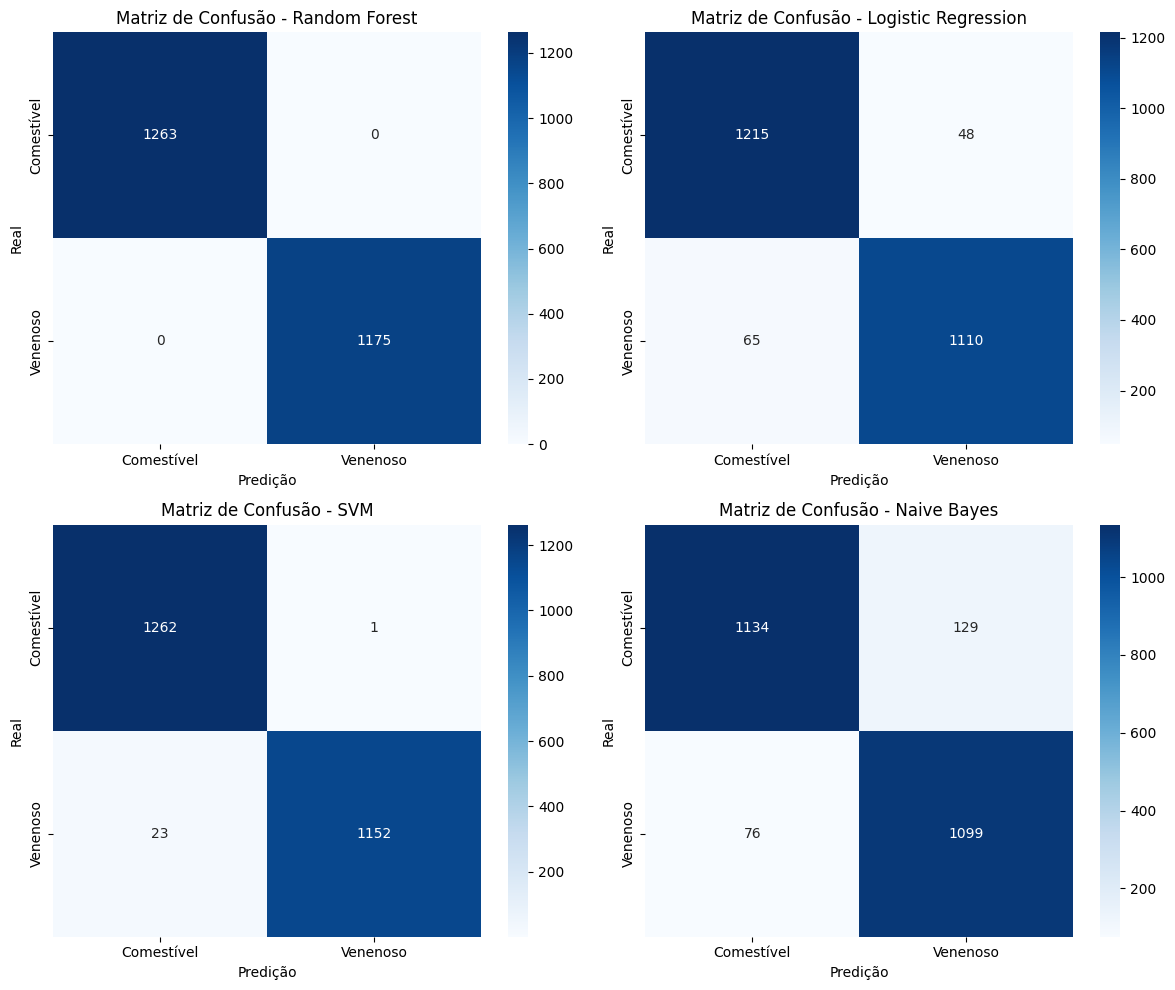


Calculando Curvas ROC...
Random Forest - AUC: 1.0000
Logistic Regression - AUC: 0.9835
SVM - AUC: 0.9999
Naive Bayes - AUC: 0.9514


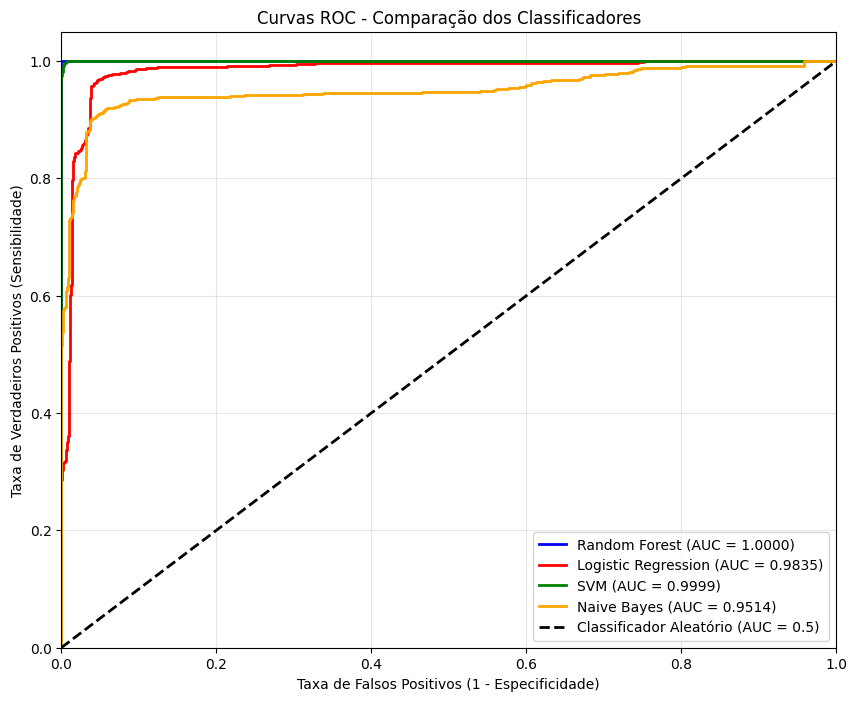


RELATÓRIO DETALHADO - ANÁLISE DE CURVA ROC

Dados do Dataset:
  - Total de amostras: 8124
  - Features: 22
  - Amostras de treino: 5686
  - Amostras de teste: 2438

Ranking dos Classificadores por AUC:
  1. Random Forest: 1.0000
  2. SVM: 0.9999
  3. Logistic Regression: 0.9835
  4. Naive Bayes: 0.9514

Detalhes por Classificador:

Random Forest:
  ├─ Acurácia: 1.0000
  ├─ Precisão: 1.0000
  ├─ TPR (Sensibilidade): 1.0000
  ├─ FPR: 0.0000
  ├─ TNR (Especificidade): 1.0000
  └─ AUC: 1.0000

Logistic Regression:
  ├─ Acurácia: 0.9537
  ├─ Precisão: 0.9585
  ├─ TPR (Sensibilidade): 0.9447
  ├─ FPR: 0.0380
  ├─ TNR (Especificidade): 0.9620
  └─ AUC: 0.9835

SVM:
  ├─ Acurácia: 0.9902
  ├─ Precisão: 0.9991
  ├─ TPR (Sensibilidade): 0.9804
  ├─ FPR: 0.0008
  ├─ TNR (Especificidade): 0.9992
  └─ AUC: 0.9999

Naive Bayes:
  ├─ Acurácia: 0.9159
  ├─ Precisão: 0.8950
  ├─ TPR (Sensibilidade): 0.9353
  ├─ FPR: 0.1021
  ├─ TNR (Especificidade): 0.8979
  └─ AUC: 0.9514

Interpretação dos Resultado

In [32]:
# Exemplo de uso
if __name__ == "__main__":
    # Inicializar e executar análise
    analyzer.run_complete_analysis()
    